In [1]:
import numpy as np
import pandas as pd
# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import rgb2hex
import os
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import signal
from ipywidgets import interact
import time
import tqdm

In [2]:
user = "tomikawa1"
# user = "aqua2"
place = r"C:\Users\%s\Box\3Kotai" %user
f_max = 5
I_max = 32

paste_num = 2
databese = r"C:\Users\%s\Box\3Kotai\experiment\BaMn2As2\2_comparison\BaMn2As2_peak_databese_paste%d.dat" %(user,paste_num,)

def file_name(date,I,f,wave,):
    if wave == None:
        return "BaMn2As2_%s_%gmA_%gHz.dat" %(date,I,f)
    elif wave == "DC":
        return "BaMn2As2_%s_%gmA_%s.dat" %(date,I,wave)
    else:
        return "BaMn2As2_%s_%gmA_%gHz_%s.dat" %(date,I,f,wave)

def df(place,date,I,f,wave,x_array,data_array):
    os.chdir(r"%s\experiment\BaMn2As2\%s" %(place,date))
    return pd.read_csv(
                file_name(date,I,f,wave,),
                sep="\t", header=None, skiprows=1, usecols=[x_array,data_array],)

def f_color(f):
    cmap = cm.get_cmap("seismic", f_max*10+1)
    color = []
    for i in range(cmap.N):
        color.append(cmap(i)[:f_max*10])
    return color[int(f*10)]

def I_color(I):
    cmap = cm.get_cmap("rainbow", I_max*10+1)
    color = []
    for i in range(cmap.N):
        color.append(cmap(i)[:I_max*10])
    return color[int(I*10)]

def data_label(data_array):
    if data_array == 0:
        return "V"
    if data_array == 7:
        return "free FBG"
    if data_array == 8:
        return "[110]"
    if data_array == 9:
        return "free FBG"
    if data_array == 10:
        return r"[1$\bar{1}$0]"
    if data_array == 17:
        return "time"
    if data_array == 19:
        return "[100]"
    if data_array == 18:
        return r"[1$\bar{1}$0]"
    if data_array == 27:
        return "time"
    else:
        return "else"

In [3]:
def raw(place,date,I,f,wave,x_array,data_array,strain,test):

    x = df(place,date,I,f,wave,x_array,data_array)[x_array]
    y = df(place,date,I,f,wave,x_array,data_array)[data_array]
    
    if test == 1:
        N = 1024            # サンプル数
        dt = 0.05          # サンプリング周期 [s]
        f1, f2 = 1, 0    # 周波数 [Hz]
        x = np.arange(0, N * dt, dt) # 時間 [s]
        y = 1.5 * np.sin(2 * np.pi * f1 * x) + np.sin(2 * np.pi * f2 * x) # データ
        
    if strain == 1:
        y = (y-y[0])/y[0]/0.78
    
    return x,y

In [4]:
def FFT(x,y,f):
    N=len(x)
    dt = (x[N-1]-x[0])/(N-1)
    
    fitted_curve = interpolate.interp1d(x, y)
    x_equidistant = np.linspace(min(x), max(x), len(x))
    y_equidistant = fitted_curve(x_equidistant)
    
    window = signal.hann(N)
    F = np.fft.fft(y_equidistant * window)
    freq = np.fft.fftfreq(N, d=dt)
    F = F / (N / 2)
    F = F * (N / np.sum(window))
    F[(freq<=0*f)]=0
    Amp = np.abs(F)
    
    peaks = [0,0,0,0]
    peaks[0] = np.max(Amp[:N//2])
    for n in (1,2,3):
        x_index_near_omega = np.amin(np.where(np.abs(freq[:N//2]-n*f)==np.amin(np.abs(freq[:N//2]-n*f))))
        y_near_omega = Amp[:N//2][x_index_near_omega]
        peaks[n] = y_near_omega
    
    return freq[:N//2], Amp[:N//2], peaks 

In [5]:
data_set=[
    [0,"20221206",(1.25,0.77),(1,),"SQU"],#Keithley
    [1,"20221214",(1.25,0.77),(1,),"SQU"],
#     [2,"20221223",(0.77,0.91,1.25,),(0.1,0.2,0.4,0.8,1,2,4,8,16,32,),"SQU"],
#     [3,"20221223",(0.77,0.91,1.25,1.51),(0.1,0.2,0.4,0.8,1,2,4,8,16,32,),"SIN"],
    [2,"20221224",(0.77,1.25,),(0.2,0.4,0.8,1,2,4,8,16,32,),"SQU"],
    [3,"20221226",(0.77,0.91,1.25,1.51,),(0.2,0.4,0.8,1,2,4,8,16,32),"SQU"],
    [4,"20221226",(0.77,0.91,1.25,1.51,),(0.2,0.4,0.8,1,2,4,8,16,32),"SIN"],
    [5,"20221226-2",(1.25,),(1,2,),"SQU"],
    [6,"20221226-2",(1.25,),(1,2,),"SIN"],
    [7,"20221226-3",(0.77,1.25,),(0.2,0.4,0.8,1,2,4,8,16,32),"SQU"],
    [8,"20221226-4",(1.25,),(2,),"SQU"],
    [9,"20221226-4",(1.25,),(2,),"SIN"],
    [10,"20221226-5-1",(1.25,),(2,),"SQU"],
    [11,"20221226-5-1",(1.25,),(2,),"SIN"],
    [12,"20221226-5-2",(1.25,),(2,),"SQU"],
    [13,"20221226-5-2",(1.25,),(2,),"SIN"],
    [14,"20221226-6",(1.25,),(2,),"OSp2"],
    [15,"20221226-6",(1.25,),(2,),"OSn2"],
    [16,"20221227-2",(0.77,0.91,1.25,1.51),(0.2,0.4,0.8,1,2,4,8,16,32,),"SQU"],
    [17,"20221227-2",(0.77,0.91,1.25,1.51),(0.2,0.4,0.8,1,2,4,8,16,32,),"SIN"],
#     [,"20221229",],offset
    [18,"20221230-2",(0.01,0.05,0.5,0.17,0.29,0.77,0.91,1.25,1.51,2.27,3.1,4.3),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SQU_1"],
    [19,"20221230-2",(0.05,0.5,0.17,0.29,0.77,0.91,1.25,1.51,2.27,3.1,4.3),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SQU_2"],
    [20,"20221230-2",(0.05,0.5,0.17,0.29,0.77,0.91,1.25,1.51,2.27,3.1,4.3),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SQU_3"],
    [21,"20221230-2",(0.01,0.05,0.5,0.17,0.29,0.77,0.91,1.25,1.51,2.27,3.1,4.3),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SIN_1"],
    [22,"20221230-2",(0.05,0.5,0.17,0.29,0.77,0.91,1.25,1.51,2.27,3.1,4.3),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SIN_2"],
    [23,"20221230-2",(0.05,0.5,0.17,0.29,0.77,0.91,1.25,1.51,2.27,3.1,4.3),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SIN_3"],
    [24,"20230111",(0.01,0.06,0.49,0.51,1,),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SQU"],
    [25,"20230111",(0.01,0.06,0.49,0.51,1,),(0.4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,),"SIN"],
    [26,"20230215",(0.05,0.91),(1,2,4,),"SQU_300K"],
    [27,"20230215",(0.05,0.91),(1,2,4,),"SIN_300K"],
    [28,"20230216",(0.05,0.91),(16,),"SQU_300K"],
    [29,"20230216",(0.05,0.91),(16,),"SIN_300K"],
    [30,"20230217-2",(0.05,0.23,0.5,),(8,16,24,),"SQU_300K"],
    [31,"20230217-2",(0.05,0.23,0.5,),(8,16,24,),"SIN_300K"],
    [32,"20230222",(0.05,0.23,0.5,),(8,16,24,),"SQU_200K"],
    [33,"20230222",(0.05,0.23,0.5,),(8,16,24,),"SIN_200K"],
    [34,"20230225",(0.05,0.23,0.5,),(8,16,24,),"SQU_100K"],
    [35,"20230225",(0.05,0.23,0.5,),(8,16,24,),"SIN_100K"],
]

exp_num = 32
date = data_set[exp_num][1]
f_list = data_set[exp_num][2]
I_list = data_set[exp_num][3]
wave = data_set[exp_num][4]
I = I_list[2]
x_array = 27
data_sample = (19,18,)
# data_sample = (8,)
test = 0
strain = 1
V_array = 0

In [6]:
def plot():
    for data_array in data_sample:
        fig = plt.figure(figsize=(10.0, 5.0))
        ax = fig.add_subplot(111)
        
        for f in f_list:
            x = raw(place,date,I,f,wave,x_array,data_array,strain,test)[0]
            y = raw(place,date,I,f,wave,x_array,data_array,strain,test)[1]
            I_real = df(place,date,I,f,wave,x_array,11)[11][1]
            f_real = df(place,date,I,f,wave,x_array,12)[12][1]
            if np.abs(I/1000 - I_real)<0.000001 and np.abs(f - f_real)<0.000001:
                plt.plot(x,y*1e6,color=f_color(f),label="$f_I$=%sHz"%(f))
            else:
                print("error:f = %gHz, I = %gmA"%(f,I))

            fig.suptitle("$\epsilon$ & fit  $I=%g$mA  %s  %s"%(I,wave,data_label(data_array)),fontsize = 20,x = 0.55, y = 0.95)
            plt.xlabel('time(s)',fontsize=20)
            plt.ylabel('strain($10^{-6}$)',fontsize=20)
            if wave != "DC":
                ax.legend(fontsize=17)
            ax.yaxis.offsetText.set_fontsize(15)
            plt.tick_params(labelsize=20)
            plt.tight_layout()

In [7]:
def plot_FFT_I(save):
    for data_array in data_sample:
        for f in tqdm.tqdm(f_list):
            fig = plt.figure(figsize=(7.0, 10.0))
            ax = fig.add_subplot(111)
            
            total_max = [0,]
            for I in I_list:
                os.chdir(r"%s\experiment\BaMn2As2\%s" %(place,date))
                if os.path.isfile(file_name(date,I,f,wave,)):
                    x = raw(place,date,I,f,wave,x_array,data_array,strain,test)[0]
                    y = raw(place,date,I,f,wave,x_array,data_array,strain,test)[1]
                    freq = FFT(x,y,f)[0]
                    Amp = FFT(x,y,f)[1]
                    total_max = []
                    total_max.append(FFT(x,y,f)[2][0]) 

            offset = np.max(total_max)
            i = len(I_list)+1
            for I in I_list[::-1]:
                i = i-1
                
                os.chdir(r"%s\experiment\BaMn2As2\%s" %(place,date))
                if os.path.isfile(file_name(date,I,f,wave,)):
                
                    x = raw(place,date,I,f,wave,x_array,data_array,strain,test)[0]
                    y = raw(place,date,I,f,wave,x_array,data_array,strain,test)[1]
                    freq = FFT(x,y,f)[0]
                    Amp = FFT(x,y,f)[1]

                    I_real = df(place,date,I,f,wave,x_array,11)[11][0]
                    f_real = df(place,date,I,f,wave,x_array,12)[12][0]
                    if np.abs(I/1000 - I_real)<0.000001 and np.abs(f - f_real)<0.000001:
                        plt.plot(freq/f,(Amp+offset*i)*1e6,color=I_color(I),label="$I=%g$ mA"%(I,))
                    else:
                        print("error:f = %gHz, I = %gmA"%(f,I))

            plt.xlim(0,5)
            fig.suptitle("FFT of $\epsilon$ (%s %gHz, %s)"%(wave,f,data_label(data_array)),fontsize = 20,x = 0.55, y = 0.97)
            plt.ylabel('strain($10^{-6}$)',fontsize=20)
            ax.yaxis.offsetText.set_fontsize(15)
            plt.xlabel('$f/f_I$',fontsize=20)
            plt.tick_params(labelsize=20)
            plt.tight_layout()
            ax.legend(fontsize=17,
                          frameon=True,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0
                         )
            if save ==1:
                os.makedirs(r"%s\experiment\BaMn2As2\figure\%s"%(place,date),exist_ok=True)
                if data_label(data_array)=="[110]":
                    plt.savefig(r"%s\experiment\BaMn2As2\3_figure\%d\BaMn2As2_%s_FFT_[110]_%s_fI=%gHz.png"%(place,date,date,wave,f))
                if data_label(data_array)==r"[1$\bar{1}$0]":
                    plt.savefig(r"%s\experiment\BaMn2As2\3_figure\%d\BaMn2As2_%s_FFT_[1-10]_%s_fI=%gHz.png"%(place,date,date,wave,f))

In [8]:
def plot_FFT_I2(harmonic,save):
    for data_array in data_sample:
        fig = plt.figure(figsize=(7.0, 10.0))
        ax = fig.add_subplot(111)
        
#         print("%s Offset calculating..."%(data_label(data_array)))
        
#         total_max = []
#         for f in tqdm.tqdm(f_list):
#             for I in I_list:
#                 x = raw(place,date,I,f,wave,x_array,data_array,strain,test)[0]
#                 y = raw(place,date,I,f,wave,x_array,data_array,strain,test)[1]
#                 freq = FFT(x,y,f)[0]
#                 Amp = FFT(x,y,f)[1]
#                 total_max.append(FFT(x,y,f)[2][0]) 

#         offset = np.max(total_max)
#         print("%s Offset = %g"%(data_label(data_array),offset))
        offset = 0
        print("%s Offset = %g"%(data_label(data_array),offset))
        print("%s plotting..."%(data_label(data_array)))
        for f in tqdm.tqdm(f_list):
            i = len(I_list)+1
            for I in I_list[::-1]:
                i = i-1
                
                os.chdir(r"%s\experiment\BaMn2As2\%s" %(place,date))
                if os.path.isfile(file_name(date,I,f,wave,)):
                
                    I_real = df(place,date,I,f,wave,x_array,11)[11][1]
                    f_real = df(place,date,I,f,wave,x_array,12)[12][1]
                    if np.abs(I/1000 - I_real)<0.0000001 and np.abs(f - f_real)<0.0000001:
                        x = raw(place,date,I,f,wave,x_array,data_array,strain,test)[0]
                        y = raw(place,date,I,f,wave,x_array,data_array,strain,test)[1]
                        freq = FFT(x,y,f)[0]
                        Amp = FFT(x,y,f)[1]
                        peak1 = FFT(x,y,f)[2][harmonic]
                        plt.plot(f,(peak1+offset*i)*1e6,color=I_color(I),marker="o")
                        plt.plot([f_list[0],f_list[len(f_list)-1]],[(0+offset*i)*1e6,(0+offset*i)*1e6],color=I_color(I),linestyle="dotted")
                        if f == f_list[0]:
                            plt.plot([],[],color=I_color(I),label="$I=%g$ mA"%(I,))
                    else:
                        print("error:f = %gHz, I = %gmA"%(f,I))

        fig.suptitle("%g harmonics (%s, %s)"%(harmonic,wave,data_label(data_array)),fontsize = 20,x = 0.55, y = 0.97)
        plt.ylabel('strain($10^{-6}$)',fontsize=20)
        ax.yaxis.offsetText.set_fontsize(15)
        plt.xlabel('$f$',fontsize=20)
        plt.tick_params(labelsize=20)
        plt.tight_layout()
        ax.legend(fontsize=17,
                      frameon=True,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0
                     )
        if save ==1:
            os.makedirs(r"%s\experiment\BaMn2As2\figure\%d"%(place,date),exist_ok=True)
            if data_label(data_array)=="[110]":
                plt.savefig(r"%s\experiment\BaMn2As2\3_figure\%d\BaMn2As2_%d_FFT_[110]_%s.png"%(place,date,date,wave))
            if data_label(data_array)==r"[1$\bar{1}$0]":
                plt.savefig(r"%s\experiment\BaMn2As2\3_figure\%d\BaMn2As2_%d_FFT_[1-10]_%s.png"%(place,date,date,wave))

In [9]:
def plot_FFT_I3(paste_num, save_data, exp_num):
    date = data_set[exp_num][1]
    f_list = data_set[exp_num][2]
    I_list = data_set[exp_num][3]
    wave = data_set[exp_num][4]
    if save_data == 1:
        i = 1
        for data_array in data_sample:
            print("%d/2"%i)
            i = i+1
            for f in tqdm.tqdm(f_list):
                for I in I_list:
                    os.chdir(r"%s\experiment\BaMn2As2\%s" %(place,date))
                    if os.path.isfile(file_name(date,I,f,wave,)):

                        I_real = df(place,date,I,f,wave,x_array,11)[11][0]
                        f_real = df(place,date,I,f,wave,x_array,12)[12][0]
                        if np.abs(I/1000 - I_real)<0.000001 and np.abs(f - f_real)<0.000001:
                            x = raw(place,date,I,f,wave,x_array,data_array,strain,test)[0]
                            y = raw(place,date,I,f,wave,x_array,data_array,strain,test)[1]
                            freq = FFT(x,y,f)[0]
                            Amp = FFT(x,y,f)[1]
                            data_top = FFT(x,y,f)[2][0]
                            peak1 = FFT(x,y,f)[2][1]
                            peak2 = FFT(x,y,f)[2][2]
                            peak3 = FFT(x,y,f)[2][3]
                            os.chdir(r"%s\experiment\BaMn2As2\2_comparison" %(place,))
                            if data_label(data_array) == "[100]":
                                axis = "[100]"
                            if data_label(data_array) == r"[1$\bar{1}$0]":
                                axis = "[1-10]"
                            f1 = open(databese, 'a')
                            f1.write("%s,%s,%s,%g,%g,%g,%g,%g,%g\n"%(date,axis,wave,f,I,data_top,peak1,peak2,peak3,))
                            f1.close()
#                         else:
#                             print("error:f = %gHz, I = %gmA"%(f,I))
                    else:
                        print("BaMn2As2_%s_%gmA_%gHz_%s.dat does not exist" %(date,I,f,wave))
    
    df2 = pd.read_csv(databese, sep=",", header=None, skiprows=0)
    df2.drop_duplicates(keep='first',inplace=True)
    df2.to_csv(databese,header=False,index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.13s/it]


time = 43.3505


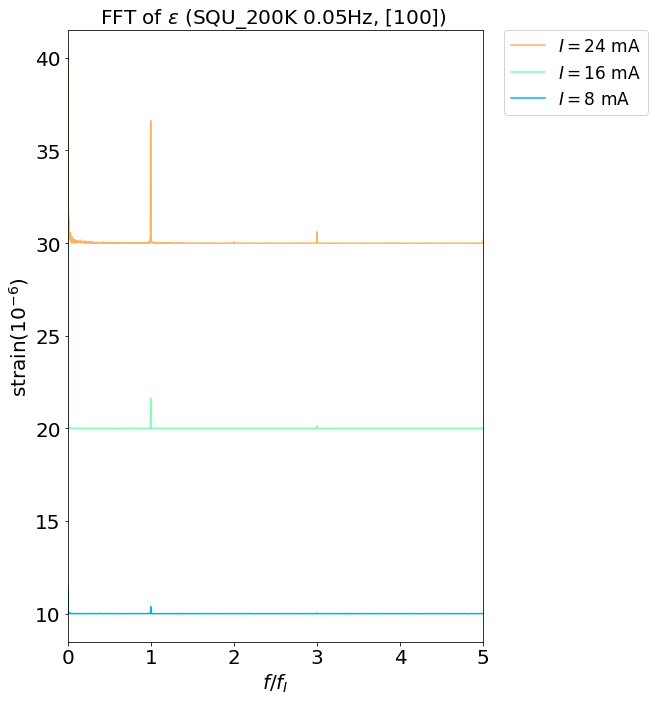

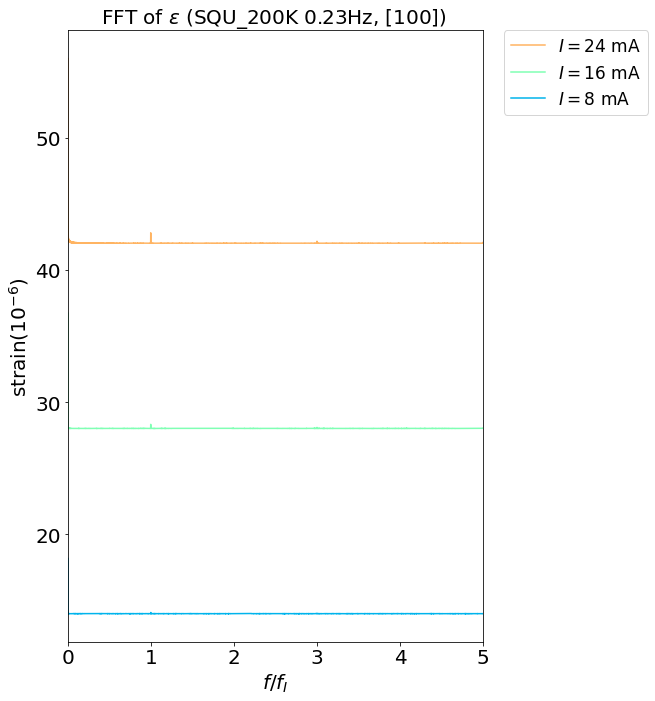

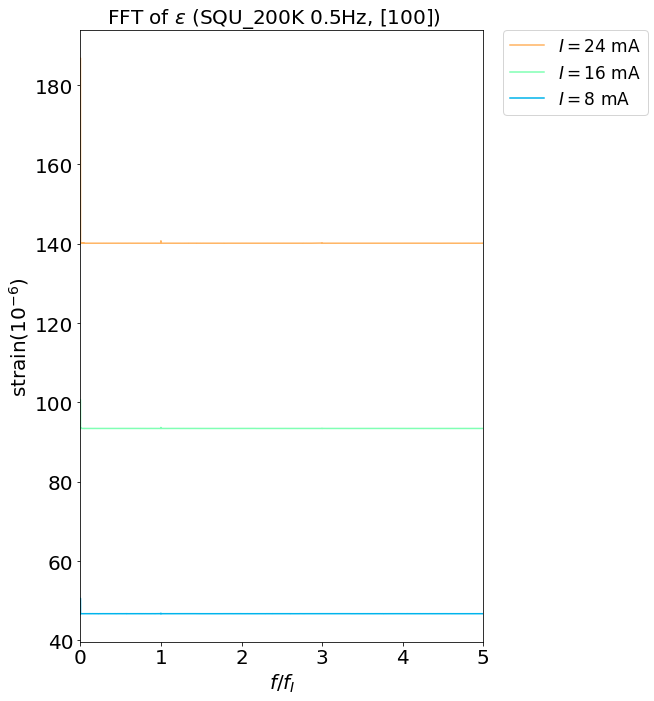

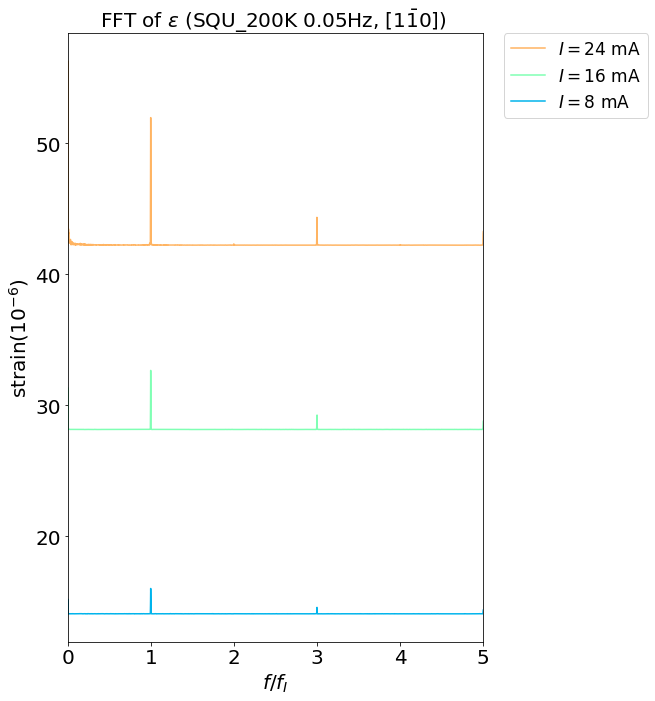

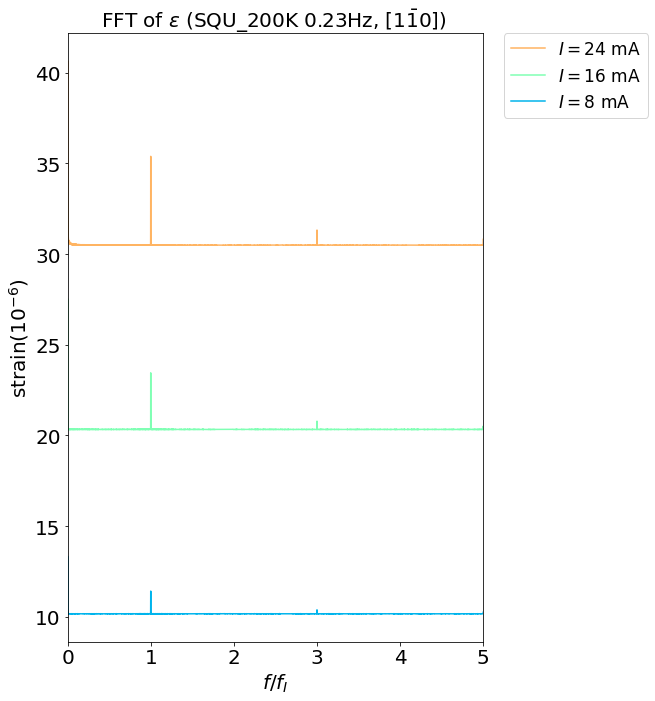

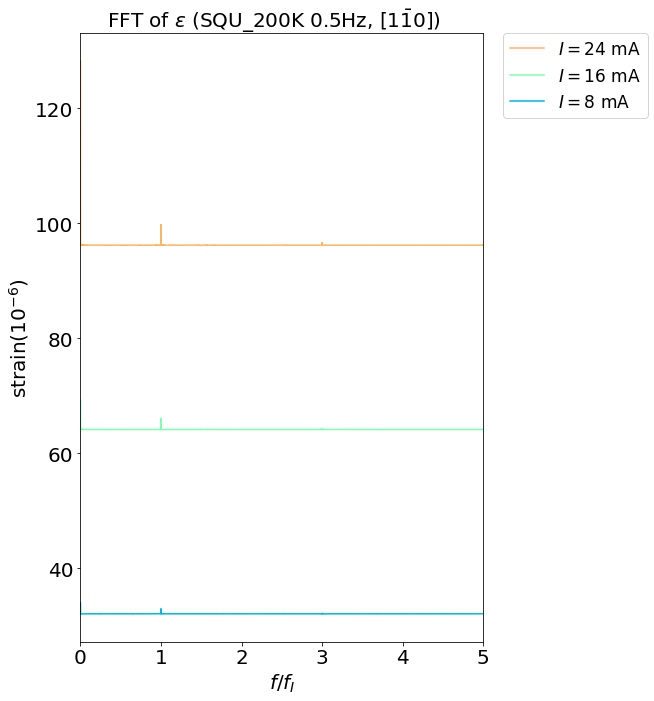

In [10]:
save = 0

time_sta = time.perf_counter()

# plot()
plot_FFT_I(save)

time_end = time.perf_counter()
tim = time_end- time_sta
print("time = %g"%(tim))

In [11]:
# save = 0

# time_sta = time.perf_counter()

# for harmonic in (1,2,3):
#     plot_FFT_I2(harmonic,save)

# time_end = time.perf_counter()
# tim = time_end- time_sta
# print("time = %g"%(tim))

In [44]:
# save_data = 1

# time_sta = time.perf_counter()

# for exp_num in (30,31,32,33,34,35):
#     plot_FFT_I3(paste_num, save_data, exp_num)

# time_end = time.perf_counter()
# tim = time_end- time_sta
# print("time = %g"%(tim))

1/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.60s/it]


2/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.93s/it]


1/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.77s/it]


2/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.99s/it]


1/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.55s/it]


2/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.45s/it]


1/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.60s/it]


2/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.66s/it]


1/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.95s/it]


2/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.57s/it]


1/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.37s/it]


2/2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.52s/it]

time = 174.106
